In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import time

from eda.corpus.reuterscorpus import ReutersCorpus

from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary, MmCorpus
from os import path
from tqdm.notebook import tqdm

In [3]:
datadir = path.abspath(path.join(os.getcwd(), "data"))

# Read in the corpus from within the archive file
fin = path.join(datadir, "reuters21578.tar.gz")
rc = ReutersCorpus(fin)

In [4]:
# filter out some of the more common words,
# and some of the less-common ones as well
rc.dictionary.filter_extremes(no_below=20, no_above=0.1)
rc.dictionary.compactify()

In [5]:
# Serialize the Reuters 21578 corpus
fout = path.join(datadir, "reuters21578.mm")
MmCorpus.serialize(fout, rc)

In [6]:
# Save the dictionary to file as text
fout = path.join(datadir, "reuters21578.dict.txt")
rc.dictionary.save_as_text(fout)

In [7]:
texts = list(rc.get_texts())

In [8]:
import pickle

fout = path.join(datadir, "texts.pkl")
with open(fout, 'wb') as f:
    pickle.dump(texts, f)

----

In [12]:
fin = path.join(datadir, "reuters21578.dict.txt")
vocabulary = Dictionary.load_from_text(fin)

In [13]:
fin = path.join(datadir, "reuters21578.mm")
mm = MmCorpus(fin)

In [14]:
fin = path.join(datadir, "texts.pkl")

with open(fin, 'rb') as f:
    texts = pickle.load(f)

In [15]:
start = 5
limit = 100
step = 5

coherence_vals = []
perplexity_vals = []

for num_topics in tqdm(range(start, limit, step)):
    lda_model = LdaMulticore(
        corpus=mm,
        id2word=vocabulary,
        num_topics=num_topics,
        passes=20,
        workers=mp.cpu_count()-1
    )
    
    perplexity_vals.append(
        np.exp2(-lda_model.log_perplexity(mm))
    )
    
    coherence_model_lda = CoherenceModel(
        model=lda_model, 
        texts=texts, 
        dictionary=vocabulary, 
        coherence='c_v'
    )
    coherence_vals.append(
        coherence_model_lda.get_coherence()
    )

  0%|          | 0/19 [00:00<?, ?it/s]

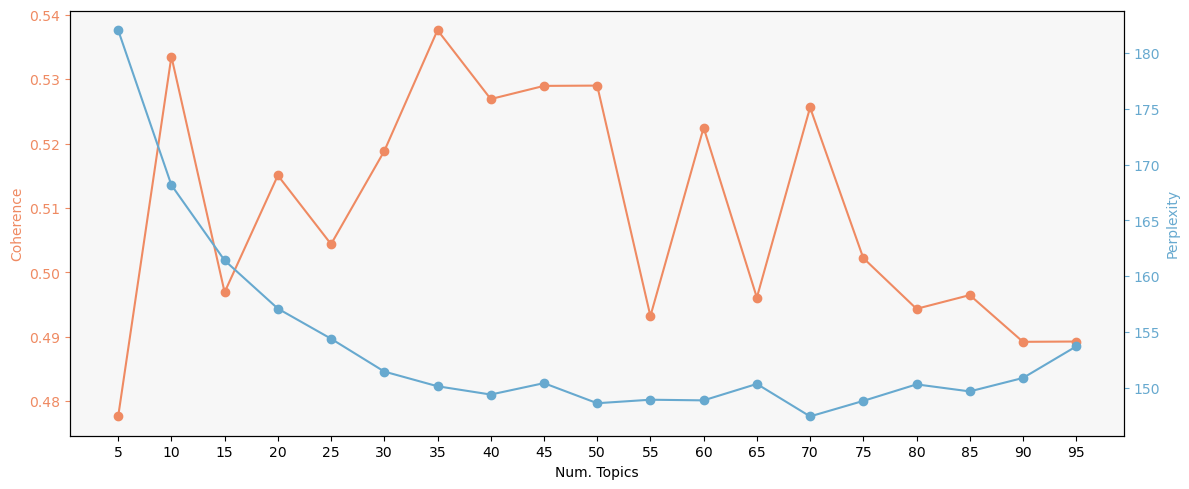

In [16]:
x = range(start, limit, step)

c1, bgcolor, c2 = ['#ef8a62', '#f7f7f7', '#67a9cf']

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence plot
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num. Topics')
ax1.set_ylabel('Coherence', color=c1)
ax1.tick_params('y', colors=c1)

# perplexity plot
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2)
ax2.tick_params('y', colors=c2)

# x-axis is shared 
ax1.set_xticks(x)
ax1.set_facecolor(bgcolor)
fig.tight_layout()
plt.show()

----

In [17]:
lda_best = LdaMulticore(
    corpus=mm,
    id2word=vocabulary,
    num_topics=35,
    passes=20,
    workers=mp.cpu_count()-1
)

In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(
    lda_best,
    mm, 
    vocabulary, 
    n_jobs=1, 
    sort_topics=False
)

pyLDAvis.display(vis)